In [49]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from mlflow.models import infer_signature

warnings.filterwarnings("ignore")

In [50]:
df = pd.read_csv('daily_occupancy.csv')


df['fecha'] = pd.to_datetime(df['fecha'])
df = df.sort_values('fecha')
df.set_index('fecha', inplace=True)
serie = df['ocupacion']

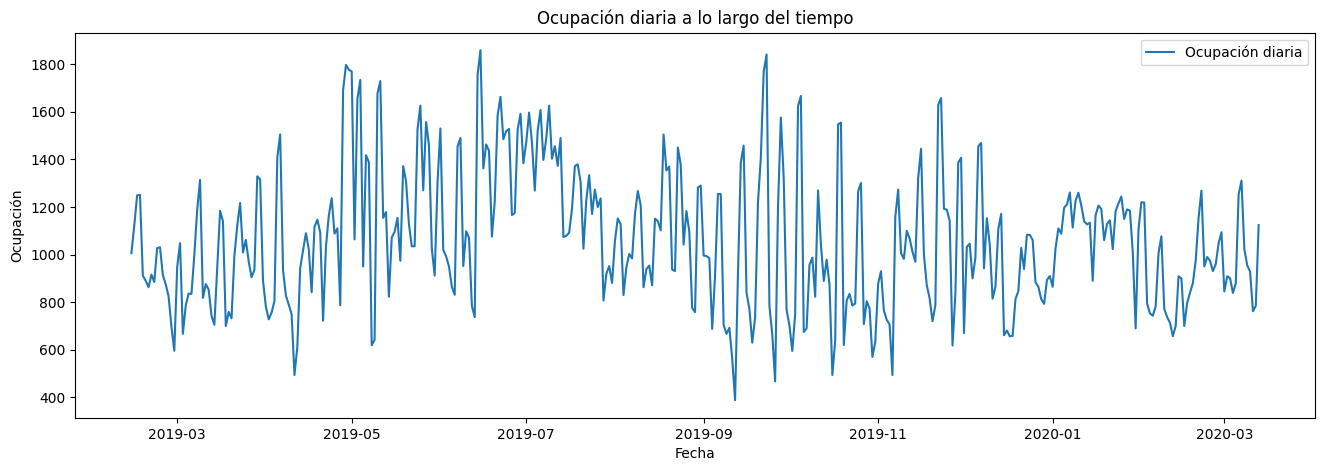

In [51]:
plt.figure(figsize=(16, 5))
plt.plot(serie, label='Ocupación diaria')
plt.title('Ocupación diaria a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Ocupación')
plt.legend()
plt.show()

In [52]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(serie)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

if result[1] < 0.05:
    print("La serie es estacionaria (p < 0.05)")
else:
    print("La serie NO es estacionaria (p >= 0.05), HAY que diferenciar.")

ADF Statistic: -2.9529996364522346
p-value: 0.0395229096880824
La serie es estacionaria (p < 0.05)


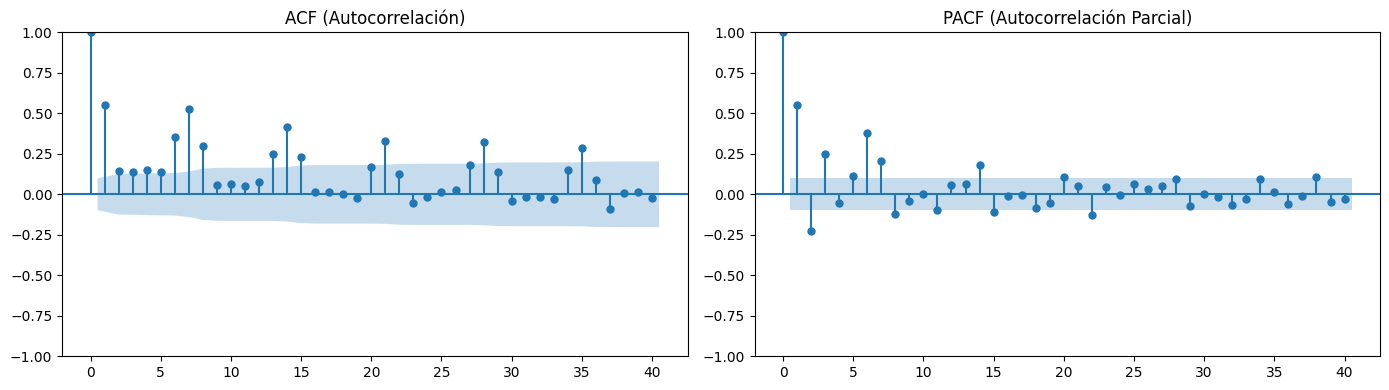

In [53]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plot_acf(serie, lags=40, ax=plt.gca())
plt.title('ACF (Autocorrelación)')

plt.subplot(1,2,2)
plot_pacf(serie, lags=40, ax=plt.gca())
plt.title('PACF (Autocorrelación Parcial)')

plt.tight_layout()
plt.savefig('sarima_acf_pacf.png', dpi=300, bbox_inches='tight')
plt.show()

In [54]:
# tamaño del test set
horizonte = 30

# Train = todos menos los últimos 30 días
train = serie.iloc[:-horizonte]
# Test = últimos 30 días
test = serie.iloc[-horizonte:]

print(f"Tamaño del set de entrenamiento: {len(train)}")
print(f"Tamaño del set de prueba: {len(test)}")
print("Fechas de test:", test.index.min(), "a", test.index.max())

Tamaño del set de entrenamiento: 365
Tamaño del set de prueba: 30
Fechas de test: 2020-02-13 00:00:00 a 2020-03-13 00:00:00


In [55]:
# Parámetros iniciales sugeridos
order = (0, 0, 0)         # p, d, q
seasonal_order = (1, 1, 1, 7)  # P, D, Q, m

# Ajustar el modelo en el set de train
modelo = SARIMAX(train, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
modelo_fit = modelo.fit(disp=False)

print(modelo_fit.summary())

                                 SARIMAX Results                                 
Dep. Variable:                 ocupacion   No. Observations:                  365
Model:             SARIMAX(1, 1, [1], 7)   Log Likelihood               -2429.359
Date:                   Wed, 21 May 2025   AIC                           4864.718
Time:                           16:50:52   BIC                           4876.292
Sample:                       02-13-2019   HQIC                          4869.325
                            - 02-12-2020                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7        0.2628      0.062      4.230      0.000       0.141       0.385
ma.S.L7       -0.8663      0.045    -19.118      0.000      -0.955      -0.777
sigma2       6.16e+04   4114

MAE: 85.36
MPE: 9.57%
RMSE: 107.34


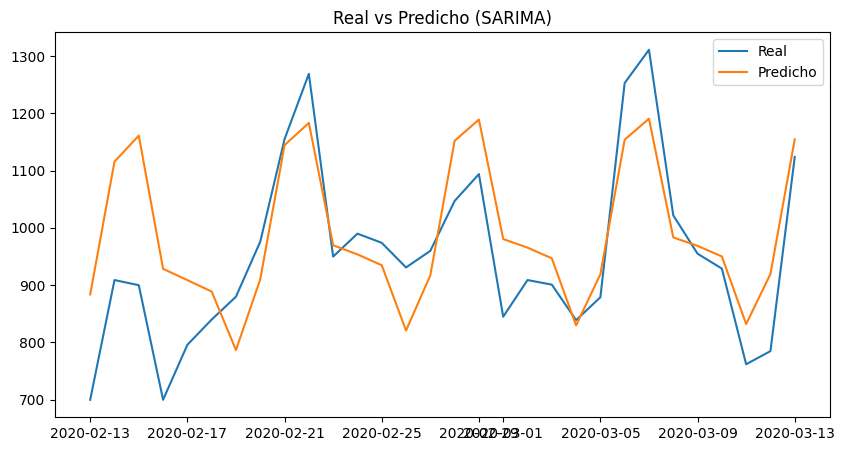

In [56]:
# Predicción de los próximos 30 días
predicciones = modelo_fit.forecast(steps=horizonte)
predicciones.index = test.index  # Para que los índices coincidan

# Cálculo de métricas
mae = mean_absolute_error(test, predicciones)
mpe = ((predicciones - test) / test).abs().mean() * 100
rmse = root_mean_squared_error(test, predicciones)

print(f"MAE: {mae:.2f}")
print(f"MPE: {mpe:.2f}%")
print(f"RMSE: {rmse:.2f}")

plt.figure(figsize=(10, 5))
plt.plot(test, label='Real')
plt.plot(predicciones, label='Predicho')
plt.title('Real vs Predicho (SARIMA)')
plt.legend()
plt.savefig('sarima_forecast.png', dpi=300, bbox_inches='tight')
plt.show()

In [57]:
# Set tracking URI and experiment
import mlflow.statsmodels

mlflow.set_tracking_uri("http://localhost:5001")
mlflow.set_experiment("Oumaji_Occupancy")

# Log params, metrics, insights.
# La signature es lo que el modelo espera (que input recibe) y lo que produce (output que genera)
signature = infer_signature(train.to_frame(), modelo_fit.forecast(steps=len(test)))

# Log with MLflow
with mlflow.start_run():    
    # Parametros del modelo
    mlflow.log_param("order", order)
    mlflow.log_param("seasonal_order", seasonal_order)
    mlflow.log_param("horizonte", horizonte)
    mlflow.log_param("enforce_stationarity", False)
    mlflow.log_param("enforce_invertibility", False)

    # Métricas
    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("MPE", mpe)
    mlflow.log_metric("RMSE", rmse)

    # Artifactos
    mlflow.log_artifact("sarima_forecast.png", artifact_path="plots")
    mlflow.log_artifact("sarima_acf_pacf.png", artifact_path="plots")

    # registrar modelo
    mlflow.statsmodels.log_model(modelo_fit, "model", 
                                registered_model_name="SARIMA", 
                                signature=signature)

2025/05/21 16:50:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Registered model 'SARIMA' already exists. Creating a new version of this model...
2025/05/21 16:50:54 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: SARIMA, version 5


🏃 View run dashing-grouse-529 at: http://localhost:5001/#/experiments/176230793224478268/runs/1446ffeb23574ab4897c051638668a17
🧪 View experiment at: http://localhost:5001/#/experiments/176230793224478268


Created version '5' of model 'SARIMA'.
